EXTRAIR FRAMES DE VIDEO

In [ ]:
import os
from contextlib import contextmanager
from typing import Generator
import re
from uuid import uuid4
import cv2

# pasta onde estão os vídeos    
input_folder = "videos_process"    #pasta de entrada dos videos 
output_folder = "frames_extracted"  #pasta onde sera salvo os frames

@contextmanager
def video_capture(file_path: str) -> Generator[cv2.VideoCapture, None, None]:
    cap = cv2.VideoCapture(file_path)
    try:
        yield cap
    except RuntimeError as e:
        print(f"Erro - {file_path}: {e}")
    finally:
        cap.release()

 # Verificar todos os arquivos na pasta 
def process_videos(input_folder: str, output_folder: str):   
    for video in os.listdir(input_folder):
        if video.lower().endswith((".mp4")):
            video_path = os.path.join(input_folder, video)
            process_frames(video_path, output_folder)

#funçao para continuar sequencia de frames de videos do mesmo voo (evitar uso do ffmmpeg para juntar videos)
def get_last_frame_number(output_folder):
    existing_frames = [f for f in os.listdir(output_folder) if re.match(r"frame_\d{4}\.jpg", f)]
    if not existing_frames:
        return 0 
    last_frame = max(int(re.search(r"\d{4}", f).group()) for f in existing_frames)
    return last_frame + 1  # para continuar contagem do ultimo numero

def process_frames(video_path: str, output_folder: str):  
    with video_capture(video_path) as cap:
        fps = int(cap.get(cv2.CAP_PROP_FPS)) 
        frame_count = 0
        #saved_count = 0     #descomentar caso nao seja seguida a funçao get_last_frame_number
        saved_count = get_last_frame_number(output_folder) #comentar essa linha caso use o seved_count = 0
        
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break  

            if frame_count % fps == 0:   #comentar para salvar os 30 frames a cada segundo / salvar 1 frame a cada segundo (atual)
                frame_filename = os.path.join(output_folder, f"frame_{saved_count:04d}.jpg")
                cv2.imwrite(frame_filename, frame)
                #frame_filename = f"{uuid4()}.jpg"  #descomentar para salvar os frames com o seus respetivos identificadores
                #frame_path = os.path.join(output_folder, frame_filename)
                #cv2.imwrite(frame_path, frame)
                saved_count += 1
            frame_count += 1


process_videos(input_folder, output_folder)



In [ ]:
!pip install autodistill autodistill-grounded-sam

In [ ]:
!pip install roboflow

In [ ]:
!pip install scikit-learn


In [ ]:
from autodistill_grounded_sam import GroundedSAM
from autodistill.detection import CaptionOntology

# Definir a ontologia para detectar o objeto desejado
base_model = GroundedSAM(ontology=CaptionOntology({"pool or water tank with edges": "pool", "circular shaped water tank": "water tank", "discarded tires on the street": "tires"})) 
# Processar imagens e salvar anotações
base_model.label(
  input_folder="frames_extracted",   # Pasta de entrada com as imagens 
  output_folder="dataset"  # Pasta onde as imagens anotadas serão salvas
)

print(" Processamento concluído! Labels salvos em ./dataset")


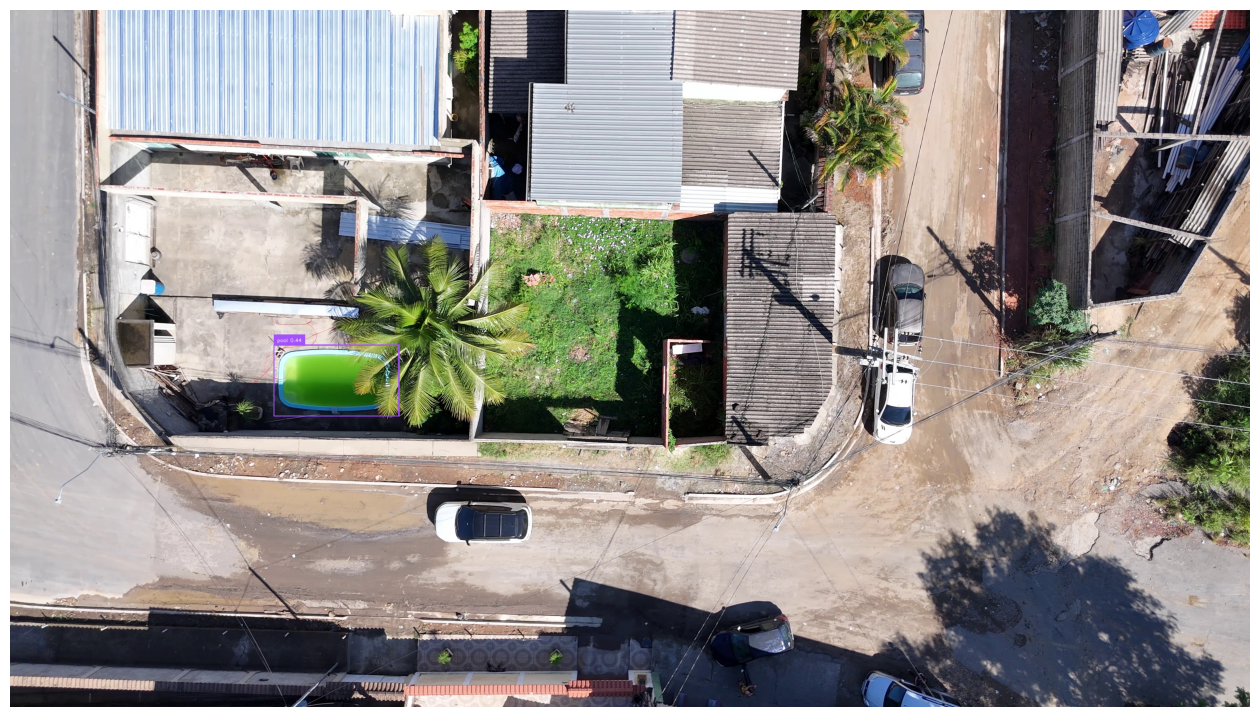

In [23]:
import supervision as sv
import cv2


img_path = "dataset/train/images/frame_0165.jpg"

image = cv2.imread(img_path)

detections = base_model.predict(img_path)
# annotate image with detections
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

labels = [
    f"{base_model.ontology.classes()[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _, _ in detections
]

annotated_frame = box_annotator.annotate(
    scene=image.copy(), detections=detections
)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame, detections=detections, labels=labels
)

sv.plot_image(annotated_frame, (16, 16))

In [ ]:
#Gerar anotaçoess coco dos arquivos da pasta dataset/valid/labels (txt)
import json
import os

# Função para ler os labels de um arquivo .txt
def read_labels(label_path):
    with open(label_path, 'r') as file:
        lines = file.readlines()
    labels = []
    for line in lines:
        parts = list(map(float, line.strip().split()))
        labels.append({
            'category_id': int(parts[0]),
            'polygon': parts[1:]
        })
    return labels

# Função para converter os labels para o formato COCO
def convert_to_coco(image_id, labels, image_width, image_height):
    coco_annotations = []
    for label in labels:
        category_id = label['category_id']
        polygon = label['polygon']
        
        # Conversao de coordenadas normalizadas para absolutas
        absolute_polygon = []
        for i in range(0, len(polygon), 2):
            x = polygon[i] * image_width
            y = polygon[i+1] * image_height
            absolute_polygon.extend([x, y])
        
        # Calcular a bbox a partir do polígono
        x_coords = absolute_polygon[::2]
        y_coords = absolute_polygon[1::2]
        x_min = min(x_coords)
        y_min = min(y_coords)
        x_max = max(x_coords)
        y_max = max(y_coords)
        bbox_width = x_max - x_min
        bbox_height = y_max - y_min
        
        # Modelo de anotação no formato COCO
        annotation = {
            'id': len(coco_annotations) + 1,  # ID para cada anotação
            'image_id': image_id,
            'category_id': category_id,
            'segmentation': [absolute_polygon],  
            'bbox': [x_min, y_min, bbox_width, bbox_height],  # Bbox
            'area': bbox_width * bbox_height,  # Area da bbox
            'iscrowd': 0  
        }
        coco_annotations.append(annotation)
    
    return coco_annotations

# Função para processar um arquivo de label e gerar uma anotaçao COCO
def process_single_label(label_path, image_id, image_width, image_height, output_folder):
    # Ler os labels do arquivo
    labels = read_labels(label_path)
    file_name = os.path.splitext(os.path.basename(label_path))[0]  # Nome do arquivo sem extensão
    # Criar o COCO para o arquivo atual
    coco_format = {
        'images': [{
            'id': image_id,
            'width': image_width,
            'height': image_height,
            'file_name': f'image_{image_id}.jpg'  
        }],
        'annotations': convert_to_coco(image_id, labels, image_width, image_height),
        'categories': [{
            'id': 0,  # ID da categoria
            'name': 'object',  # Nome da categoria
            'supercategory': 'none'
        }]
    }
    
    # Salvar anotaçao COCO em um arquivo separado
    output_path = os.path.join(output_folder, f'coco_annotations_{file_name}.json')
    with open(output_path, 'w') as f:
        json.dump(coco_format, f, indent=4)
    
    print(f"Arquivo {label_path} processado. JSON salvo em {output_path}")

# Função para processar todos os labels de uma pasta, se nao existir a pasta, sera criado em seguida
def process_labels_folder(labels_folder, image_width, image_height, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Increntar para todos arquivos na pasta de labels
    for idx, filename in enumerate(os.listdir(labels_folder)):
        if filename.endswith('.txt'):
            label_path = os.path.join(labels_folder, filename)
            image_id = idx + 1 
            
            # Processando arquivo de label e gerar um COCO separado
            process_single_label(label_path, image_id, image_width, image_height, output_folder)

labels_folder = 'dataset/valid/labels'  # Pasta contendo os arquivos .txt (ao alternar para detectar as piscinas, finaliza a conversao dos labels da caixa dagua para deletar os txt dessa pasta em seguida)
image_width = 3840  # Largura da imagem
image_height = 2160  # Altura da imagem
output_folder = 'dataset/valid/annotations'  # Pasta para salvar os JSONs COCO (apos converter os rotulos de caixa dagua e for iniciar a conversao das piscina, altere o caminho para annotation_pool)

# Processar todos os labels
process_labels_folder(labels_folder, image_width, image_height, output_folder)

Arquivo dataset/valid/labels\frame_0144.txt processado. JSON salvo em dataset/valid/annotations_watertank\coco_annotations_frame_0144.json


In [ ]:
#verificaçao das anotaçoes json com imagens respectivas a detecçao (caixa dagua ou piscina). caso de duvidas
import cv2
import json
import matplotlib.pyplot as plt

image_path = "dataset/valid/images/frame_0144.jpg"  #caminho correto da imagem
coco_json_path = "dataset/valid/annotations_watertank/coco_annotations_1.json" #caminho correto da anotaçao

image = cv2.imread(image_path)
if image is None:
    print(" Erro ao carregar a imagem. Verifique o caminho.")
    exit()

#imagem para RGB (para plot)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# carregar JSON de anotações
with open(coco_json_path, "r") as f:
    coco_data = json.load(f)

# cópia da imagem para desenhar as bbox
image_with_bboxes = image_rgb.copy()

#Cor, espessura e ajustes das bbox
bbox_color = (0, 255, 0)  # Verde
bbox_thickness = 2
for annotation in coco_data["annotations"]:
    x_min, y_min, width, height = annotation["bbox"]
    x_max = x_min + width
    y_max = y_min + height

    #Desenhar retângulo na imagem
    cv2.rectangle(image_with_bboxes, 
                  (int(x_min), int(y_min)), 
                  (int(x_max), int(y_max)), 
                  bbox_color, bbox_thickness)

    # Adicionar ID da categoria
    label = f"ID: {annotation['category_id']}"
    cv2.putText(image_with_bboxes, label, 
                (int(x_min), int(y_min) - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, 
                bbox_color, bbox_thickness)

#Imagem com bbox
plt.figure(figsize=(10, 6))
plt.imshow(image_with_bboxes)
plt.axis("off")  
plt.show()
